In [1]:
import numpy as np
from numpy.random import random, choice
from math import factorial
from scipy.special import gamma
import matplotlib.pyplot as plt
%matplotlib inline

### An Analysis of Thomas Bayes' ball-rolling thought-experiment {-}

The following thought experiment is adapted from Section II of Thomas Bayes' seminal 1763 paper,  ["An Essay towards solving a Problem in the Doctrine of Chances"](https://web.archive.org/web/20110410085940/http://www.stat.ucla.edu/history/essay.pdf). I have used the modern treatment of the problem given by Prof. Sean R. Eddy in ["What is Bayesian Statistics?", Nature Biotechnology volume 22, pages1177–1178(2004)](https://www.nature.com/articles/nbt0904-1177).

Alice and Bob are playing a game in which the first person to get 6 points wins. The way each point is decided is a little strange. The Casino has a pool table that Alice and Bob can’t see. Before the game begins, the Casino rolls an initial ball onto the table, which comes to rest at a completely random position, which the Casino marks. Then, each point is decided by
the Casino rolling another ball onto the table randomly. If it comes to rest to the left of the initial mark, Alice wins the point; to the right of the mark, Bob wins the point. The Casino reveals nothing to Alice and Bob except who won each point.

Clearly, the probability that Alice wins a point is the fraction of the table to the left of the mark—call this probability p; and Bob’s probability of winning a point is 1 – p. Because the Casino rolled the initial ball to a random position, before any points were decided every value of p was equally probable. **The mark is only set once per game**, so p is the same for every point (in a particular game).

Say, after $8$ rolls of any particular game, we end up with a situation $A:B=5:3$. Given this information, and only this information (we do not know $p$), what is the likelihood that Bob wins this game? Bayesian analysis tells us the probability is roughly $1/11$, whereas Alice winning has a probability $10/11$ - the ratio of $A:B$ probabilities is therefore $10$. Let us verify this by actually running a large number of trials, discarding those that do not end up at $5:3$ after $8$ rolls, and of those that do, let us analyse how often Alice or Bob actually win. 

In [2]:
N=100000
Actr, Bctr, Bexps= 0, 0, 0   
#Actr counts no. of Alice wins, Bctr no. of Bob wins, Bexps no. of games which end up 5:3 to Alice after 8 rolls
for i in range(N):
    prob=random() #sets up the respective prior probs. of Alice/Bob wins for a particular game
    a=np.array([0,1]) #here, let (0,1)==(Bob,Alice) for any particular roll, so 2 Bob and 1 Alice win(s) is denoted 001
    x=choice(a,size=8,p=[prob, 1-prob]) #simulating 8 rolls of the dice
    if np.sum(x)==5:  #This is only true if the game has ended up 5:3 to Alice, otherwise loop starts again
        Bexps+=1
        y=choice(a,size=3,p=[prob, 1-prob])
        if np.sum(y)==0: #This is only true if, once game is at 5:3 to Alice, Bob wins the next 3 rolls
            Bctr+=1
        else:
            Actr+=1
print("After", N, "total experiments, we ended up with", Bexps, "trials where Alice:Bob=5:3 after 8 rolls.")
print("Following this, Alice wins", Actr, "times and Bob wins", Bctr, "times.")
print("Their ratio is", Actr/Bctr, "while the theoretical Bayesian prediction would be 10.")

After 100000 total experiments, we ended up with 11376 trials where Alice:Bob=5:3 after 8 rolls.
Following this, Alice wins 10282 times and Bob wins 1094 times.
Their ratio is 9.39853747714808 while the theoretical Bayesian prediction would be 10.


As we can see, the simulation turns out close to the Bayesian prediction. However, let us now try something more ambitious. What if at every iteration, the Bayesian probability (for Bob or Alice wins in a particular game) keeps updating after every roll, i.e. at every new input of information? Let us now try to implement this dynamic Bayesian situation. 

For example, say the prior probabilities of Alice/Bob wins in a roll be fixed for a particular game at $(p,1-p)$. Now let us take the first roll. Say it lands for Alice. Then the probability that Bob wins from this point is the composite probability of him winning the next 6/6 rolls, 6/7 rolls, ...., 6/10 rolls, (all Bernoulli/binomial trials). However, there is a catch - the game lasts, say, 7 rolls and goes to Bob IF AND ONLY IF the winning roll for Bob happens on the 7th roll. Basically if Bob wins the next 6 rolls, then it doesn't get to the 7th roll at all. So we have to assume the $n^{th}$ roll is always for Bob, if Bob is to win in these Bernoulli trials after $n$ rolls. So the probability that Bob wins 6 out of the next 7 rolls is NOT $\binom{7}{6}p^{7-6}(1-p)^6$, which is the typical binomial formula, but $\binom{6}{5}p (1-p)^6$ - this is because there can be no distinguishable permutation involving the last roll - it always goes for Bob. So the total probability that Bob wins, after the first roll has gone to Alice is

\begin{equation}
    E(B)=\binom{5}{5} (1-p)^6 p^0 + \binom{6}{5} (1-p)^6 p^1 + \binom{7}{5} (1-p)^6 p^2 + \binom{8}{5} (1-p)^6 p^3 + \binom{9}{5} (1-p)^6 p^4
\end{equation}

We stop just before Alice has a chance to win 5 out of the next 11 tries. We do a similar computation for every roll, until either Alice or Bob get 6 wins. Now we have to generalize/formalize this notion and implement it in a formula.

Say at any point during a game, the score stands at Alice$=x$, Bob$=y$. Of course, both $x,y<6$, otherwise the game ends. Let us also assume that for all the rolls during this game, the respective prior probabilities (the quantity whose value we don't actually know in the Bayesian analysis) is $[p, 1-p]$. Let us now try to evaluate the Bayesian likelihood for Bob to eventually get to 6 wins before Alice, and thereby win the game, which is mathematically represented as

\begin{align}
    E(B)=\int_0^1 dp\, P(B) P(p| A=x, B=y)
\end{align}

Here, $P(B)$ is the probability that Bob would win the game, with the score at $x:y$, assuming we knew $p$. To be more explicit, this requires that Bob win $6-y$ rolls before Alice can win $6-x$ rolls. Therefore, the maximum number of rolls that can be allowed before one party, by mathematical default, will win is $11-x-y$.  

(**NOTE:** This is the part of the computation that requires the most thought, so let's go over this carefully - the game ends when either Alice or Bob get to $6$. At that point whoever has lost, has $5$ or fewer wins. So the sum of both Alice and Bob wins when the game ends can, AT MOST, be $6+5=11$. This is the same as saying you need at most $11$ rolls to decide a winner in this game. Now that $x+y$ rolls have already happened, the maximum number of rolls left to decide a winner is $11-x-y$.) 

However, as we have already discussed, you only need to check the next $10-x-y$ rolls out of which Bob has to win $5-y$ rolls - the last roll always goes to Bob if Bob is to win this game. So for Bob to win, he needs to win $5-y$ out of the next $5-y$ rolls, $5-y$ out of the next $5-y+1$ rolls, ... , all the way up to $5-y$ out of the next $10-x-y$ rolls, which can be written as
\begin{align}
    P(B)=\sum_{n=5-y}^{10-x-y} \binom{n}{5-y}(1-p)^{6-y}p^{n-(5-y)}
\end{align}

Now the term $P(p| A=x, B=y)$ term, which is basically the likelihood that the prior probabilities of Alice/Bob wins are $[p,1-p]$, given that we have reached $A:B=x:y$, can be rewritten using the Bayes' theorem as
\begin{align}
    P(p|A=x, B=y)=\frac{P(A=x, B=y|p) P(p)}{\int_0^1 dp' P(A=x, B=y|p')P(p')}
\end{align}

Now we know how to calculate $P(A=x, B=y|p)$, which is simply the likelihood of getting an event $A:B=x:y$ in the first place, assuming we know $p$, and it is given by the binomial formula
\begin{align}
    P(A=x, B=y|p) = \binom{x+y}{x} p^x (1-p)^y
\end{align}

We are now in a position to compute the Bayesian likelihood of Bob winning the game, given the information that it has reached the stage $A:B=x:y$, which is
\begin{align}
    E(B)&=\frac{\int_0^1 dp \left[\sum_{n=5-y}^{10-x-y} \binom{n}{5-y}(1-p)^{6-y}p^{n-(5-y)}\right]p^x(1-p)^y}{\int_0^1 dp\, p^x (1-p)^y}\\
    &= \frac{\int_0^1 dp \left[\sum_{n=5-y}^{10-x-y} \binom{n}{5-y}(1-p)^6 p^{n-(5-x-y)}\right]}{\int_0^1 dp\, p^x (1-p)^y}
\end{align}

The prior probabilities $P(p)$ are constant for any particular game and can be factored out and canceled between numerator and denominator. The remaining denominator is a simple enough beta integral which can be written as
\begin{align}
    \int_0^1 dp\, p^x (1-p)^y &=\frac{\Gamma{(x+1)} \Gamma{(y+1)}}{\Gamma{(x+y+2)}}\\
    &=\frac{x! y!}{(x+y+1)!}
\end{align}
For the numerator, the $p$-independent summation can be taken out of the integral, and the whole thing can be written as a summation of beta integrals as follows:

\begin{align}
    \int_0^1 dp \left[\sum_{n=5-y}^{10-x-y} \binom{n}{5-y}(1-p)^{6}p^{n-(5-x-y)}\right] &=\sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \int_0^1 dp\, (1-p)^6 p^{n+x+y-5}\\
    &= \sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \frac{\Gamma{(7)}\Gamma{(n+x+y-4)}}{\Gamma{(n+x+y+3)}}\\
    &= \sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \frac{6! (n+x+y-5)!}{(n+x+y+2)!}
\end{align}

Therefore, if at any point, the game ends up at $A:B=x:y$, then the Bayesian likelihood of Bob winning the game (with 6 points) is
\begin{align}
    E(B)&=\frac{\sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \frac{6! (n+x+y-5)!}{(n+x+y+2)!}}{\frac{x! y!}{(x+y+1)!}}\\
    &= \sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \frac{6! (n+x+y-5)! (x+y+1)!}{(n+x+y+2)! x! y!}\\
    &= \sum_{n=5-y}^{10-x-y} \binom{n}{5-y} \frac{\binom{x+y}{x}}{\binom{n+x+y+1}{6}} \frac{x+y+1}{n+x+y+2}
\end{align}

Little messy, but we have a formula! Is it any good? Let's verify for the situation $A:B=5:3$, where we know the Bayesian probability of Bob eventually winning should be $1/11$. What does the general formula tell us? 
\begin{align}
    E(B)&= \sum_{n=2}^{2} \binom{n}{5-y} \frac{\binom{x+y}{x}}{\binom{n+x+y+1}{6}} \frac{x+y+1}{n+x+y+2}\\
    &=\binom{2}{2}\frac{\binom{8}{5}}{\binom{11}{6}}\frac{9}{12}\\
    &=\frac{8\cdot 7 \cdot 6}{3\cdot 2 \cdot 1} \cdot \frac{5\cdot 4 \cdot 3 \cdot 2}{11 \cdot 10 \cdot 9 \cdot 8 \cdot 7} \cdot \frac{9}{12}\\
    &=\frac{1}{11}
\end{align}

It works! The Bayesian probability for the other possibility (Alice winning) is simply $1-E(B)$, because they are mutually exclusive and exhaustive. 

The value of p for this game was 0.7096204849995658
The rolls in the game were (Alice=1, Bob=0): [1 1 0 0 0 0 1 0 1 0]
The Bayesian probability for Bob winning varies as  [0.22727273 0.09090909 0.27272727 0.5        0.71645022 0.87878788
 0.72727273 0.90909091 0.77272727 1.        ]


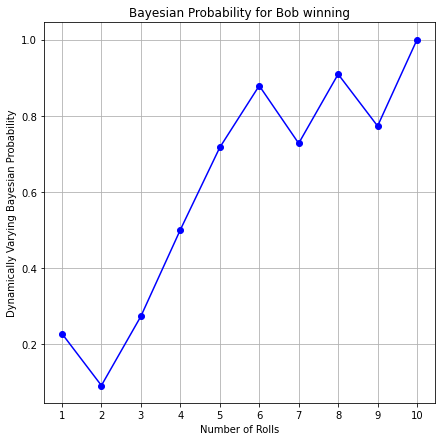

In [97]:
def nCr(n,r): return factorial(n)/(factorial(r)*factorial(n-r))  #defining the factorial function
def EB(x,y):   #setting up the formula to calculate Bayesian probability of Bob winning after every roll (i.e for new info) 
    EB=0
    if y==6:  #if y=6, Bob has already won, and the Bayesian probability should be 1 - this has to be put in by hand
        return (1)
    else:
        for n in range(5-y, 11-x-y):
            EB+=(nCr(n,5-y)*nCr(x+y,x)*(x+y+1))/(nCr(n+x+y+1,6)*(n+x+y+2))
        return (EB)
prob=random()  #this sets the value of p for the game
p=np.array([prob, 1-prob])  
a=np.array([0,1])  #Here, Alice=1, Bob=0 for every roll
BayProbs=np.array([])  #Empty Array to store and update the values of the Bayesian prob. of Bob winning
x=choice(a,size=None,p=p)
ctr=1
while np.sum(x)<6 and ctr-np.sum(x)<6:
    BayProbs=np.append(BayProbs, EB(np.sum(x),ctr-np.sum(x)))
    x=np.append(x, choice(a,size=None,p=p))
    ctr+=1
if np.sum(x)==6:
    BayProbs=np.append(BayProbs, 0)
if ctr-np.sum(x)==6:
    BayProbs=np.append(BayProbs, 1)
n=np.arange(1, ctr+1)
plt.figure(figsize=(7, 7))
ax=plt.axes()
ax.set_xticks(n)
plt.grid(True)
plt.plot(n,BayProbs, 'bo-')
plt.title("Bayesian Probability for Bob winning")
plt.xlabel("Number of Rolls")
plt.ylabel("Dynamically Varying Bayesian Probability")
print("The value of p for this game was", prob)
print("The rolls in the game were (Alice=1, Bob=0):", x)
print("The Bayesian probability for Bob winning varies as ", BayProbs)

This code (and the formula) can be easily modified for most zero-sum two-player games of chance. 